# Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F

/opt/miniconda3/envs/deep_env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
clases = ['avion', 'automovil', 'pajaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camion']

print("Cantidad de datos de entrenamiento:", x_train.shape[0])
print("Cantidad de datos de test:", x_test.shape[0])

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") 

x_train = torch.tensor(x_train, dtype=torch.float32, device=device).reshape(50000, -1) / 255.0
x_test  = torch.tensor(x_test, dtype=torch.float32, device=device).reshape(10000, -1) / 255.0
y_train = torch.tensor(y_train.flatten(), dtype=torch.long, device=device)
y_test  = torch.tensor(y_test.flatten(), dtype=torch.long, device=device)

print("Tamaño de los datos de entrenamiento:", x_train.shape)
print("Tamaño de los datos de test:", x_test.shape)

#print el menor y el mayor valor de los pixeles de las imagenes
print("Valor mínimo de los pixeles en x_train:", torch.min(x_train).item())
print("Valor máximo de los pixeles en x_train:", torch.max(x_train).item())

Cantidad de datos de entrenamiento: 50000
Cantidad de datos de test: 10000
Tamaño de los datos de entrenamiento: torch.Size([50000, 3072])
Tamaño de los datos de test: torch.Size([10000, 3072])
Valor mínimo de los pixeles en x_train: 0.0
Valor máximo de los pixeles en x_train: 1.0


# Ej. 3

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        # pesos y bias como parámetros (en lugar de nn.Linear)
        self.w1 = nn.Parameter(torch.empty(100, 3072))  # (out, in)
        self.b1 = nn.Parameter(torch.zeros(100))
        self.w2 = nn.Parameter(torch.empty(10, 100))
        self.b2 = nn.Parameter(torch.zeros(10))

        # Inicialización (Xavier -> la buena para sigmoide)
        nn.init.xavier_uniform_(self.w1)
        nn.init.zeros_(self.b1)
        nn.init.xavier_uniform_(self.w2)
        nn.init.zeros_(self.b2)

        def fc1(x):
            # x: (B, 3072), w1: (100, 3072) -> x @ w1.T -> (B, 100)
            return torch.matmul(x, self.w1.t()) + self.b1

        def fc2(x):
            # x: (B, 100), w2: (10, 100) -> x @ w2.T -> (B, 10)
            return torch.matmul(x, self.w2.t()) + self.b2

        self.fc1 = fc1
        self.fc2 = fc2

        self.to(device) # lo mando a la GPU

    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))   # capa oculta sigmoide
        logits = self.fc2(h)             # salida lineal (logits)
        return logits


    # ---------- Gradientes manuales dL/dlogits ----------
    @staticmethod
    def grad_logits_mse(logits, y_onehot):
        # L = mean ||logits - y||^2  -> dL/dlogits = 2*(logits - y)/B
        B = logits.shape[0]
        return 2.0 * (logits - y_onehot) / B

    @staticmethod
    def grad_logits_softmax_ce(logits, y_onehot):
        # L = mean CE(softmax(logits), y) -> dL/dlogits = softmax(logits) - y  (promediado)
        B = logits.shape[0]
        probs = torch.softmax(logits, dim=1)
        return (probs - y_onehot) / B

    # ---------- Loss helpers (autograd estándar) ----------
    @staticmethod
    def loss_mse(logits, y_onehot):
        return F.mse_loss(logits, y_onehot, reduction='mean')

    @staticmethod
    def loss_softmax_ce(logits, y_int64):
        # CrossEntropyLoss espera (logits, target_int) y aplica softmax+NLL
        return F.cross_entropy(logits, y_int64, reduction='mean')

    # ---------- Entrenamiento configurable ----------
    def train_model(
        self,
        x_train,
        y_train,
        x_test=None,
        y_test=None,
        epochs: int = 10,
        batch_size: int = 128,
        lr: float = 1e-1,
        lambda_l2: float = 1e-4,
        device=None,
        shuffle: bool = True,
        momentum: float = 0.9,
        loss_type: str = "mse",          # "mse" | "softmax"
        grad_type: str = "mse",          # "mse" | "softmax" (solo si use_manual_grad=True)
        use_manual_grad: bool = False,   # True: usa gradiente manual en logits
    ):
        # Asegurar device consistente
        if device is not None:
            if next(self.parameters()).device != device:
                self.to(device)
            if x_train.device != device: x_train = x_train.to(device)
            if y_train.device != device: y_train = y_train.to(device)
            if x_test  is not None and x_test.device  != device: x_test  = x_test.to(device)
            if y_test  is not None and y_test.device  != device: y_test  = y_test.to(device)

        ds_tr = torch.utils.data.TensorDataset(x_train, y_train)
        dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=shuffle)

        # L2 vía weight_decay (no duplicamos L2 en la loss)
        optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum, weight_decay=lambda_l2)

        history = {"loss": [], "acc": []}
        history_test = {"loss": [], "acc": []}

        for epoch in range(1, epochs + 1):
            self.train()
            run_loss, correct, total = 0.0, 0, 0

            for xb, yb in dl_tr:
                optimizer.zero_grad()
                logits = self(xb)

                if use_manual_grad:
                    # Elegir gradiente manual en los logits
                    if grad_type.lower() == "mse":
                        y_one = F.one_hot(yb, num_classes=10).float()
                        grad = self.grad_logits_mse(logits, y_one)
                    elif grad_type.lower() == "softmax":
                        y_one = F.one_hot(yb, num_classes=10).float()
                        grad = self.grad_logits_softmax_ce(logits, y_one)
                    else:
                        raise ValueError("grad_type debe ser 'mse' o 'softmax'")

                    # Propagar gradiente custom desde logits
                    logits.backward(grad)
                    optimizer.step()

                    # Para registrar una loss coherente (solo métrica):
                    if loss_type.lower() == "mse":
                        loss_val = self.loss_mse(logits.detach(), y_one)
                    elif loss_type.lower() == "softmax":
                        loss_val = self.loss_softmax_ce(logits.detach(), yb)
                    else:
                        raise ValueError("loss_type debe ser 'mse' o 'softmax'")

                else:
                    # Autograd estándar con la loss elegida
                    if loss_type.lower() == "mse":
                        y_one = F.one_hot(yb, num_classes=10).float()
                        loss_val = self.loss_mse(logits, y_one)
                    elif loss_type.lower() == "softmax":
                        loss_val = self.loss_softmax_ce(logits, yb)
                    else:
                        raise ValueError("loss_type debe ser 'mse' o 'softmax'")

                    loss_val.backward()
                    optimizer.step()

                # Métricas
                run_loss += loss_val.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

            epoch_loss = run_loss / total
            epoch_acc = correct / total
            history["loss"].append(epoch_loss)
            history["acc"].append(epoch_acc)

            # Evaluación
            if x_test is not None and y_test is not None:
                self.eval()
                with torch.no_grad():
                    # evaluar en mini-batches
                    ds_te = torch.utils.data.TensorDataset(x_test, y_test)
                    dl_te = torch.utils.data.DataLoader(ds_te, batch_size=batch_size)
                    t_loss, t_correct, t_total = 0.0, 0, 0
                    for xbt, ybt in dl_te:
                        logitst = self(xbt)
                        if loss_type.lower() == "mse":
                            y1t = F.one_hot(ybt, num_classes=10).float()
                            lt = self.loss_mse(logitst, y1t)
                        else:
                            lt = self.loss_softmax_ce(logitst, ybt)
                        t_loss += lt.item() * xbt.size(0)
                        t_correct += (logitst.argmax(1) == ybt).sum().item()
                        t_total += xbt.size(0)
                    t_loss /= t_total
                    t_acc  = t_correct / t_total
                history_test["loss"].append(t_loss)
                history_test["acc"].append(t_acc)
                print(f"Época {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | "
                      f"Test Loss: {t_loss:.4f} | Test Acc: {t_acc*100:.2f}%")
            else:
                print(f"Época {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}%")

        return history, history_test

In [5]:
model = NeuralNet(device=device)
history_3, history_test_3= model.train_model(
    x_train, y_train, x_test, y_test,
    epochs=100, batch_size=256,
    lr=1e-2,
    lambda_l2=1e-4,      # L2 via weight_decay dentro del optimizador
    device=device,
    loss_type="mse",     # "mse" o "softmax"
)

Época 01 | Loss: 0.1050 | Acc: 22.09% | Test Loss: 0.0846 | Test Acc: 29.03%
Época 02 | Loss: 0.0837 | Acc: 30.67% | Test Loss: 0.0830 | Test Acc: 31.78%
Época 03 | Loss: 0.0825 | Acc: 33.27% | Test Loss: 0.0820 | Test Acc: 34.07%
Época 04 | Loss: 0.0817 | Acc: 34.37% | Test Loss: 0.0815 | Test Acc: 34.94%
Época 05 | Loss: 0.0812 | Acc: 35.63% | Test Loss: 0.0811 | Test Acc: 35.30%
Época 06 | Loss: 0.0808 | Acc: 36.23% | Test Loss: 0.0807 | Test Acc: 36.00%
Época 07 | Loss: 0.0804 | Acc: 36.97% | Test Loss: 0.0803 | Test Acc: 37.01%
Época 08 | Loss: 0.0801 | Acc: 37.36% | Test Loss: 0.0800 | Test Acc: 36.99%
Época 09 | Loss: 0.0798 | Acc: 37.74% | Test Loss: 0.0798 | Test Acc: 37.65%
Época 10 | Loss: 0.0796 | Acc: 38.03% | Test Loss: 0.0796 | Test Acc: 38.12%
Época 11 | Loss: 0.0793 | Acc: 38.38% | Test Loss: 0.0792 | Test Acc: 38.43%
Época 12 | Loss: 0.0791 | Acc: 38.78% | Test Loss: 0.0793 | Test Acc: 37.42%
Época 13 | Loss: 0.0789 | Acc: 38.95% | Test Loss: 0.0789 | Test Acc: 38.96%

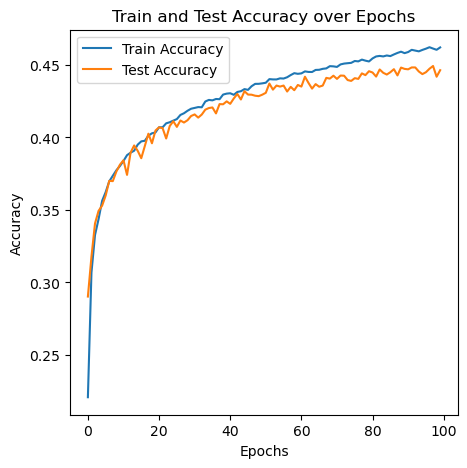

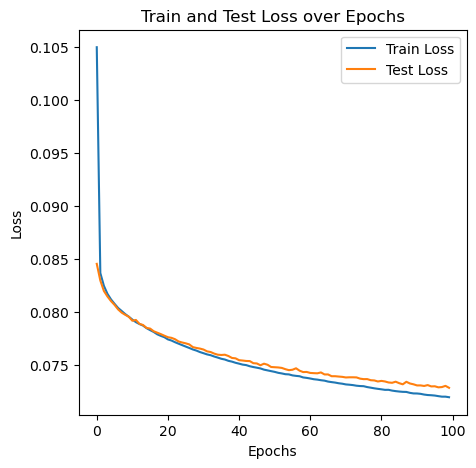

In [ ]:
#plot accuracy
plt.figure(figsize=(5,5))
plt.plot(history_3['acc'], label='Train Accuracy')
plt.plot(history_test_3['acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

#plot loss
plt.figure(figsize=(5,5))
plt.plot(history_3['loss'], label='Train Loss')
plt.plot(history_test_3['loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xscale("log")
# plt.yscale("log")
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()

#   Ej. 4

In [7]:
model = NeuralNet(device=device)
history_4, history_test_4 = model.train_model(
    x_train, y_train, x_test, y_test,
    epochs=100, batch_size=256,
    lr=1e-2,
    lambda_l2=1e-4,      # L2 via weight_decay dentro del optimizador
    device=device,
    loss_type="softmax",     # Softmax -> cross-entropy
)



Época 01 | Loss: 2.0618 | Acc: 27.46% | Test Loss: 1.9190 | Test Acc: 32.43%
Época 02 | Loss: 1.8743 | Acc: 34.62% | Test Loss: 1.8391 | Test Acc: 36.15%
Época 03 | Loss: 1.8189 | Acc: 36.60% | Test Loss: 1.8035 | Test Acc: 36.94%
Época 04 | Loss: 1.7807 | Acc: 37.89% | Test Loss: 1.7672 | Test Acc: 38.62%
Época 05 | Loss: 1.7559 | Acc: 38.87% | Test Loss: 1.7493 | Test Acc: 38.35%
Época 06 | Loss: 1.7340 | Acc: 39.72% | Test Loss: 1.7224 | Test Acc: 39.78%
Época 07 | Loss: 1.7145 | Acc: 40.32% | Test Loss: 1.7186 | Test Acc: 40.14%
Época 08 | Loss: 1.6971 | Acc: 40.92% | Test Loss: 1.7004 | Test Acc: 40.92%
Época 09 | Loss: 1.6784 | Acc: 41.78% | Test Loss: 1.6740 | Test Acc: 41.63%
Época 10 | Loss: 1.6614 | Acc: 42.10% | Test Loss: 1.6679 | Test Acc: 41.86%
Época 11 | Loss: 1.6469 | Acc: 42.83% | Test Loss: 1.6504 | Test Acc: 42.38%
Época 12 | Loss: 1.6338 | Acc: 42.99% | Test Loss: 1.6352 | Test Acc: 43.12%
Época 13 | Loss: 1.6191 | Acc: 43.72% | Test Loss: 1.6278 | Test Acc: 43.39%

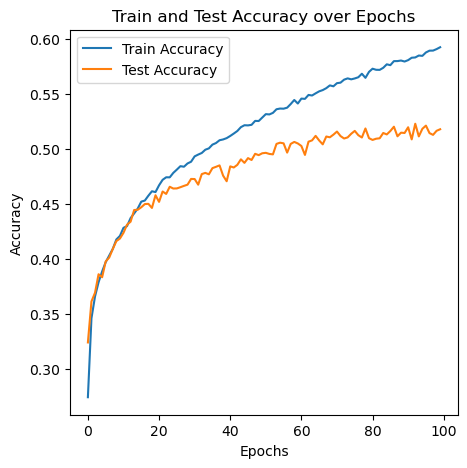

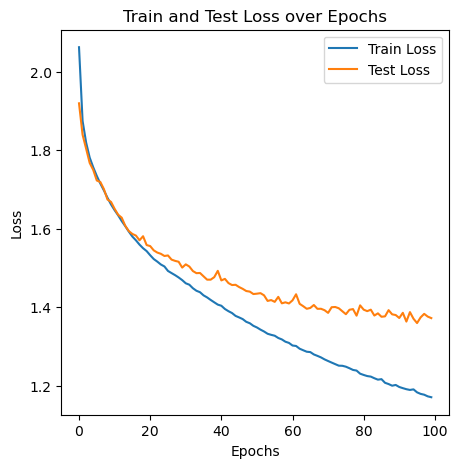

In [9]:
#plot accuracy
plt.figure(figsize=(5,5))
plt.plot(history_4['acc'], label='Train Accuracy')
plt.plot(history_test_4['acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

#plot loss
plt.figure(figsize=(5,5))
plt.plot(history_4['loss'], label='Train Loss')
plt.plot(history_test_4['loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xscale("log")
# plt.yscale("log")
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# class NeuralNet(nn.Module):
#     def __init__(self, device, hidden_f="relu", output_f="sigmoid"):
#         super().__init__()
#         self.device = device
#         self.fc1 = nn.Linear(3072, 100)
#         self.fc2 = nn.Linear(100, 10)
#         self.hidden_f = hidden_f
#         self.output_f = output_f

#         # Inicialización acorde a la activación
#         if self.hidden_f == "relu":
#             nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')  # ← He/Kaiming para ReLU
#             nn.init.zeros_(self.fc1.bias)
#         elif self.hidden_f == "sigmoid":
#             nn.init.xavier_uniform_(self.fc1.weight)                        # ← Xavier para sigmoide
#             nn.init.zeros_(self.fc1.bias)
#         else:
#             raise ValueError("hidden_f debe ser 'relu' o 'sigmoid'")

#         self.to(device)

#     def forward(self, x):
#         if self.hidden_f == "relu":
#             h = torch.relu(self.fc1(x))      # capa oculta ReLU
#         elif self.hidden_f == "sigmoid":
#             h = torch.sigmoid(self.fc1(x))   # capa oculta sigmoide
#         else:
#             raise ValueError("hidden_f debe ser 'relu' o 'sigmoid'")
        
#         if self.output_f == "sigmoid":
#             out = torch.sigmoid(self.fc2(h)) # salida sigmoidal
#             return out
#         elif self.output_f == "linear":
#             logits = self.fc2(h)             # salida lineal (logits)
#             return logits
#         else:
#             raise ValueError("output_f debe ser 'sigmoid' o 'linear'")
        

#     # ---------- Gradientes manuales dL/dlogits ----------
#     @staticmethod
#     def grad_logits_mse(logits, y_onehot):
#         # L = mean ||logits - y||^2  -> dL/dlogits = 2*(logits - y)/B
#         B = logits.shape[0]
#         return 2.0 * (logits - y_onehot) / B

#     @staticmethod
#     def grad_logits_softmax_ce(logits, y_onehot):
#         # L = mean CE(softmax(logits), y) -> dL/dlogits = softmax(logits) - y  (promediado)
#         B = logits.shape[0]
#         probs = torch.softmax(logits, dim=1)
#         return (probs - y_onehot) / B

#     # ---------- Loss helpers (autograd estándar) ----------
#     @staticmethod
#     def loss_mse(logits, y_onehot):
#         return F.mse_loss(logits, y_onehot, reduction='mean')

#     @staticmethod
#     def loss_softmax_ce(logits, y_int64):
#         # CrossEntropyLoss espera (logits, target_int) y aplica softmax+NLL
#         return F.cross_entropy(logits, y_int64, reduction='mean')

#     # ---------- Entrenamiento configurable ----------
#     def train_model(
#         self,
#         x_train,
#         y_train,
#         x_test=None,
#         y_test=None,
#         epochs: int = 10,
#         batch_size: int = 128,
#         lr: float = 1e-1,
#         lambda_l2: float = 1e-4,
#         device=None,
#         shuffle: bool = True,
#         momentum: float = 0.9,
#         loss_type: str = "mse",          # "mse" | "softmax"
#         grad_type: str = "mse",          # "mse" | "softmax" (solo si use_manual_grad=True)
#         use_manual_grad: bool = False,   # True: usa gradiente manual en logits
#     ):
#         # Asegurar device consistente
#         if device is not None:
#             if next(self.parameters()).device != device:
#                 self.to(device)
#             if x_train.device != device: x_train = x_train.to(device)
#             if y_train.device != device: y_train = y_train.to(device)
#             if x_test  is not None and x_test.device  != device: x_test  = x_test.to(device)
#             if y_test  is not None and y_test.device  != device: y_test  = y_test.to(device)

#         ds_tr = torch.utils.data.TensorDataset(x_train, y_train)
#         dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=shuffle)

#         # L2 vía weight_decay (no duplicamos L2 en la loss)
#         optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum, weight_decay=lambda_l2)

#         history = {"loss": [], "acc": []}
#         history_test = {"loss": [], "acc": []}

#         for epoch in range(1, epochs + 1):
#             self.train()
#             run_loss, correct, total = 0.0, 0, 0

#             for xb, yb in dl_tr:
#                 optimizer.zero_grad()
#                 logits = self(xb)

#                 if use_manual_grad:
#                     # Elegir gradiente manual en los logits
#                     if grad_type.lower() == "mse":
#                         y_one = F.one_hot(yb, num_classes=10).float()
#                         grad = self.grad_logits_mse(logits, y_one)
#                     elif grad_type.lower() == "softmax":
#                         y_one = F.one_hot(yb, num_classes=10).float()
#                         grad = self.grad_logits_softmax_ce(logits, y_one)
#                     else:
#                         raise ValueError("grad_type debe ser 'mse' o 'softmax'")

#                     # Propagar gradiente custom desde logits
#                     logits.backward(grad)
#                     optimizer.step()

#                     # Para registrar una loss coherente (solo métrica):
#                     if loss_type.lower() == "mse":
#                         loss_val = self.loss_mse(logits.detach(), y_one)
#                     elif loss_type.lower() == "softmax":
#                         loss_val = self.loss_softmax_ce(logits.detach(), yb)
#                     else:
#                         raise ValueError("loss_type debe ser 'mse' o 'softmax'")

#                 else:
#                     # Autograd estándar con la loss elegida
#                     if loss_type.lower() == "mse":
#                         y_one = F.one_hot(yb, num_classes=10).float()
#                         loss_val = self.loss_mse(logits, y_one)
#                     elif loss_type.lower() == "softmax":
#                         loss_val = self.loss_softmax_ce(logits, yb)
#                     else:
#                         raise ValueError("loss_type debe ser 'mse' o 'softmax'")

#                     loss_val.backward()
#                     optimizer.step()

#                 # Métricas
#                 run_loss += loss_val.item() * xb.size(0)
#                 preds = logits.argmax(dim=1)
#                 correct += (preds == yb).sum().item()
#                 total += xb.size(0)

#             epoch_loss = run_loss / total
#             epoch_acc = correct / total
#             history["loss"].append(epoch_loss)
#             history["acc"].append(epoch_acc)

#             # Evaluación
#             if x_test is not None and y_test is not None:
#                 self.eval()
#                 with torch.no_grad():
#                     # evaluar en mini-batches
#                     ds_te = torch.utils.data.TensorDataset(x_test, y_test)
#                     dl_te = torch.utils.data.DataLoader(ds_te, batch_size=batch_size)
#                     t_loss, t_correct, t_total = 0.0, 0, 0
#                     for xbt, ybt in dl_te:
#                         logitst = self(xbt)
#                         if loss_type.lower() == "mse":
#                             y1t = F.one_hot(ybt, num_classes=10).float()
#                             lt = self.loss_mse(logitst, y1t)
#                         else:
#                             lt = self.loss_softmax_ce(logitst, ybt)
#                         t_loss += lt.item() * xbt.size(0)
#                         t_correct += (logitst.argmax(1) == ybt).sum().item()
#                         t_total += xbt.size(0)
#                     t_loss /= t_total
#                     t_acc  = t_correct / t_total
#                 history_test["loss"].append(t_loss)
#                 history_test["acc"].append(t_acc)
#                 print(f"Época {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | "
#                       f"Test Loss: {t_loss:.4f} | Test Acc: {t_acc*100:.2f}%")
#             else:
#                 print(f"Época {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}%")

#         return history, history_test

#   Ej. 5

## ReLU - Sigmoide

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        # pesos y bias como parámetros (en lugar de nn.Linear)
        self.w1 = nn.Parameter(torch.empty(100, 3072))  # (out, in)
        self.b1 = nn.Parameter(torch.zeros(100))
        self.w2 = nn.Parameter(torch.empty(10, 100))
        self.b2 = nn.Parameter(torch.zeros(10))

        # Inicialización (Xavier -> la buena para sigmoide)
        nn.init.xavier_uniform_(self.w1)
        nn.init.zeros_(self.b1)
        nn.init.xavier_uniform_(self.w2)
        nn.init.zeros_(self.b2)

        def fc1(x):
            # x: (B, 3072), w1: (100, 3072) -> x @ w1.T -> (B, 100)
            return torch.matmul(x, self.w1.t()) + self.b1

        def fc2(x):
            # x: (B, 100), w2: (10, 100) -> x @ w2.T -> (B, 10)
            return torch.matmul(x, self.w2.t()) + self.b2

        self.fc1 = fc1
        self.fc2 = fc2

        self.to(device) # lo mando a la GPU

    def forward(self, x):
        h = torch.relu(self.fc1(x))   # capa oculta ReLU
        logits = torch.sigmoid(self.fc2(h))           # salida sigmoidal
        return logits


    # ---------- Gradientes manuales dL/dlogits ----------
    @staticmethod
    def grad_logits_mse(logits, y_onehot):
        # L = mean ||logits - y||^2  -> dL/dlogits = 2*(logits - y)/B
        B = logits.shape[0]
        return 2.0 * (logits - y_onehot) / B

    @staticmethod
    def grad_logits_softmax_ce(logits, y_onehot):
        # L = mean CE(softmax(logits), y) -> dL/dlogits = softmax(logits) - y  (promediado)
        B = logits.shape[0]
        probs = torch.softmax(logits, dim=1)
        return (probs - y_onehot) / B

    # ---------- Loss helpers (autograd estándar) ----------
    @staticmethod
    def loss_mse(logits, y_onehot):
        return F.mse_loss(logits, y_onehot, reduction='mean')

    @staticmethod
    def loss_softmax_ce(logits, y_int64):
        # CrossEntropyLoss espera (logits, target_int) y aplica softmax+NLL
        return F.cross_entropy(logits, y_int64, reduction='mean')

    # ---------- Entrenamiento configurable ----------
    def train_model(
        self,
        x_train,
        y_train,
        x_test=None,
        y_test=None,
        epochs: int = 10,
        batch_size: int = 128,
        lr: float = 1e-1,
        lambda_l2: float = 1e-4,
        device=None,
        shuffle: bool = True,
        momentum: float = 0.9,
        loss_type: str = "mse",          # "mse" | "softmax"
        grad_type: str = "mse",          # "mse" | "softmax" (solo si use_manual_grad=True)
        use_manual_grad: bool = False,   # True: usa gradiente manual en logits
    ):
        # Asegurar device consistente
        if device is not None:
            if next(self.parameters()).device != device:
                self.to(device)
            if x_train.device != device: x_train = x_train.to(device)
            if y_train.device != device: y_train = y_train.to(device)
            if x_test  is not None and x_test.device  != device: x_test  = x_test.to(device)
            if y_test  is not None and y_test.device  != device: y_test  = y_test.to(device)

        ds_tr = torch.utils.data.TensorDataset(x_train, y_train)
        dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=shuffle)

        # L2 vía weight_decay (no duplicamos L2 en la loss)
        optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum, weight_decay=lambda_l2)

        history = {"loss": [], "acc": []}
        history_test = {"loss": [], "acc": []}

        for epoch in range(1, epochs + 1):
            self.train()
            run_loss, correct, total = 0.0, 0, 0

            for xb, yb in dl_tr:
                optimizer.zero_grad()
                logits = self(xb)

                if use_manual_grad:
                    # Elegir gradiente manual en los logits
                    if grad_type.lower() == "mse":
                        y_one = F.one_hot(yb, num_classes=10).float()
                        grad = self.grad_logits_mse(logits, y_one)
                    elif grad_type.lower() == "softmax":
                        y_one = F.one_hot(yb, num_classes=10).float()
                        grad = self.grad_logits_softmax_ce(logits, y_one)
                    else:
                        raise ValueError("grad_type debe ser 'mse' o 'softmax'")

                    # Propagar gradiente custom desde logits
                    logits.backward(grad)
                    optimizer.step()

                    # Para registrar una loss coherente (solo métrica):
                    if loss_type.lower() == "mse":
                        loss_val = self.loss_mse(logits.detach(), y_one)
                    elif loss_type.lower() == "softmax":
                        loss_val = self.loss_softmax_ce(logits.detach(), yb)
                    else:
                        raise ValueError("loss_type debe ser 'mse' o 'softmax'")

                else:
                    # Autograd estándar con la loss elegida
                    if loss_type.lower() == "mse":
                        y_one = F.one_hot(yb, num_classes=10).float()
                        loss_val = self.loss_mse(logits, y_one)
                    elif loss_type.lower() == "softmax":
                        loss_val = self.loss_softmax_ce(logits, yb)
                    else:
                        raise ValueError("loss_type debe ser 'mse' o 'softmax'")

                    loss_val.backward()
                    optimizer.step()

                # Métricas
                run_loss += loss_val.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

            epoch_loss = run_loss / total
            epoch_acc = correct / total
            history["loss"].append(epoch_loss)
            history["acc"].append(epoch_acc)

            # Evaluación
            if x_test is not None and y_test is not None:
                self.eval()
                with torch.no_grad():
                    # evaluar en mini-batches
                    ds_te = torch.utils.data.TensorDataset(x_test, y_test)
                    dl_te = torch.utils.data.DataLoader(ds_te, batch_size=batch_size)
                    t_loss, t_correct, t_total = 0.0, 0, 0
                    for xbt, ybt in dl_te:
                        logitst = self(xbt)
                        if loss_type.lower() == "mse":
                            y1t = F.one_hot(ybt, num_classes=10).float()
                            lt = self.loss_mse(logitst, y1t)
                        else:
                            lt = self.loss_softmax_ce(logitst, ybt)
                        t_loss += lt.item() * xbt.size(0)
                        t_correct += (logitst.argmax(1) == ybt).sum().item()
                        t_total += xbt.size(0)
                    t_loss /= t_total
                    t_acc  = t_correct / t_total
                history_test["loss"].append(t_loss)
                history_test["acc"].append(t_acc)
                print(f"Época {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | "
                      f"Test Loss: {t_loss:.4f} | Test Acc: {t_acc*100:.2f}%")
            else:
                print(f"Época {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}%")

        return history, history_test
    



## softmax

In [4]:
model = NeuralNet(device=device)
history_5_1, history_test_5_1 = model.train_model(
    x_train, y_train, x_test, y_test,
    epochs=100, batch_size=256,
    lr=0.1,
    lambda_l2=1e-4,      # L2 via weight_decay dentro del optimizador
    device=device,
    loss_type="softmax",     # Softmax -> cross-entropy
)

Época 01 | Loss: 2.0729 | Acc: 29.76% | Test Loss: 2.0196 | Test Acc: 35.12%
Época 02 | Loss: 2.0002 | Acc: 35.55% | Test Loss: 1.9835 | Test Acc: 36.56%
Época 03 | Loss: 1.9718 | Acc: 37.54% | Test Loss: 1.9692 | Test Acc: 38.16%
Época 04 | Loss: 1.9565 | Acc: 39.23% | Test Loss: 1.9558 | Test Acc: 39.73%
Época 05 | Loss: 1.9452 | Acc: 40.00% | Test Loss: 1.9575 | Test Acc: 39.46%
Época 06 | Loss: 1.9368 | Acc: 40.72% | Test Loss: 1.9417 | Test Acc: 39.89%
Época 07 | Loss: 1.9279 | Acc: 41.52% | Test Loss: 1.9304 | Test Acc: 41.73%
Época 08 | Loss: 1.9235 | Acc: 41.70% | Test Loss: 1.9297 | Test Acc: 41.18%
Época 09 | Loss: 1.9194 | Acc: 42.24% | Test Loss: 1.9191 | Test Acc: 43.03%
Época 10 | Loss: 1.9168 | Acc: 42.45% | Test Loss: 1.9232 | Test Acc: 43.51%
Época 11 | Loss: 1.9086 | Acc: 43.29% | Test Loss: 1.9223 | Test Acc: 42.55%
Época 12 | Loss: 1.9036 | Acc: 43.48% | Test Loss: 1.9193 | Test Acc: 43.31%
Época 13 | Loss: 1.9010 | Acc: 44.02% | Test Loss: 1.9155 | Test Acc: 43.29%

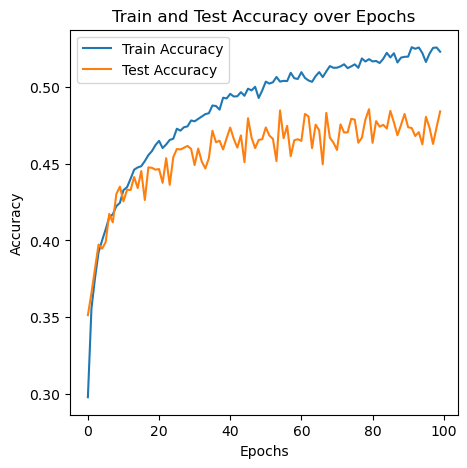

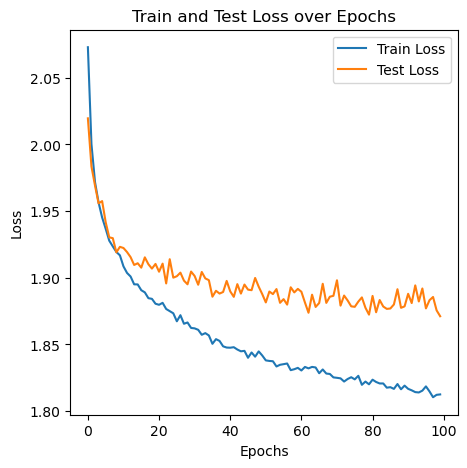

In [6]:
#plot accuracy
plt.figure(figsize=(5,5))
plt.plot(history_5_1['acc'], label='Train Accuracy')
plt.plot(history_test_5_1['acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

#plot loss
plt.figure(figsize=(5,5))
plt.plot(history_5_1['loss'], label='Train Loss')
plt.plot(history_test_5_1['loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xscale("log")
# plt.yscale("log")
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()

## MSE

In [7]:
model = NeuralNet(device=device)
history_5_2, history_test_5_2 = model.train_model(
    x_train, y_train, x_test, y_test,
    epochs=100, batch_size=256,
    lr=0.1,
    lambda_l2=1e-4,      # L2 via weight_decay dentro del optimizador
    device=device,
    loss_type="mse",     # Softmax -> cross-entropy
)

Época 01 | Loss: 0.1001 | Acc: 10.87% | Test Loss: 0.0969 | Test Acc: 15.28%
Época 02 | Loss: 0.0946 | Acc: 18.83% | Test Loss: 0.0916 | Test Acc: 23.07%
Época 03 | Loss: 0.0906 | Acc: 24.92% | Test Loss: 0.0898 | Test Acc: 25.53%
Época 04 | Loss: 0.0868 | Acc: 28.58% | Test Loss: 0.0846 | Test Acc: 29.69%
Época 05 | Loss: 0.0820 | Acc: 33.77% | Test Loss: 0.0798 | Test Acc: 35.51%
Época 06 | Loss: 0.0788 | Acc: 37.55% | Test Loss: 0.0779 | Test Acc: 38.41%
Época 07 | Loss: 0.0771 | Acc: 38.95% | Test Loss: 0.0767 | Test Acc: 38.58%
Época 08 | Loss: 0.0758 | Acc: 40.05% | Test Loss: 0.0755 | Test Acc: 40.28%
Época 09 | Loss: 0.0747 | Acc: 41.17% | Test Loss: 0.0743 | Test Acc: 41.17%
Época 10 | Loss: 0.0739 | Acc: 41.67% | Test Loss: 0.0736 | Test Acc: 42.07%
Época 11 | Loss: 0.0731 | Acc: 42.51% | Test Loss: 0.0732 | Test Acc: 41.88%
Época 12 | Loss: 0.0724 | Acc: 43.37% | Test Loss: 0.0732 | Test Acc: 42.50%
Época 13 | Loss: 0.0719 | Acc: 43.84% | Test Loss: 0.0723 | Test Acc: 42.71%

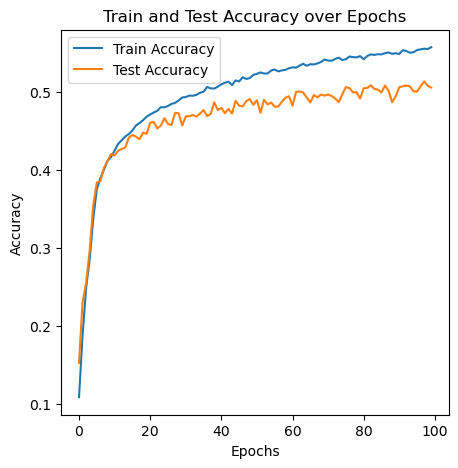

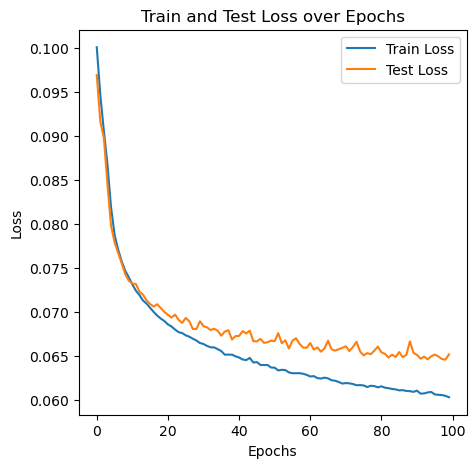

In [8]:
#plot accuracy
plt.figure(figsize=(5,5))
plt.plot(history_5_2['acc'], label='Train Accuracy')
plt.plot(history_test_5_2['acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

#plot loss
plt.figure(figsize=(5,5))
plt.plot(history_5_2['loss'], label='Train Loss')
plt.plot(history_test_5_2['loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xscale("log")
# plt.yscale("log")
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()